# Workflow

This colab aims in labeling the CA data for super spread week, safe week and improvement week as per the 'number of cases' increasing or decreasing every week.

Idea: 
* compute 7 -day moving average
* 14 days data compare with next 14 days rolling window
* split the % as buckets 
* label the data as per bucket

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture

In [11]:
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')


In [12]:
!ls  '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/'

CA_Covid-19.csv     Newyork_combinedAug22.csv  NY-CovidAug22.csv
CA-CovidAug22.csv   Newyork_combined.csv       queens_all_combined.csv
mask_rule.csv	    NY_Covid-19.csv	       queens_all_filtered.csv
mask_rule_data.csv  NY-CovidAug21.csv	       Queens_county.csv


# Loading NY data

In [13]:
NY_combined_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/CA-CovidAug22.csv',low_memory=False)
NY_combined_data.head()

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths
0,2020-01-22,California,6001.0,0,0,0,0
1,2020-01-23,California,6001.0,0,0,0,0
2,2020-01-24,California,6001.0,0,0,0,0
3,2020-01-25,California,6001.0,0,0,0,0
4,2020-01-26,California,6001.0,0,0,0,0


## Computing rolling average

In [19]:
NY_combined_data.iloc[:,5]

0        0
1        0
2        0
3        0
4        0
        ..
12562    0
12563    0
12564    0
12565    0
12566    0
Name: New cases, Length: 12567, dtype: int64

In [17]:
df = pd.DataFrame(columns=['Date','FIPS','New cases','rolling_avg_new_cases'])


In [18]:
NY_counties = NY_combined_data['FIPS'].unique()

for county in NY_counties:
  county_data = NY_combined_data[NY_combined_data['FIPS'] == county]
  #print(county_data.iloc[:,15])
  county_data['rolling_avg_new_cases'] = county_data.iloc[:,5].rolling(window=7).mean()
  df = df.append(county_data)

df.head()

,Date,FIPS,New cases,rolling_avg_new_cases,Province_State,Confirmed,Deaths,New deaths
0,2020-01-22,6001.0,0,NaN,California,0.0,0.0,0.0
1,2020-01-23,6001.0,0,NaN,California,0.0,0.0,0.0
2,2020-01-24,6001.0,0,NaN,California,0.0,0.0,0.0
3,2020-01-25,6001.0,0,NaN,California,0.0,0.0,0.0
4,2020-01-26,6001.0,0,NaN,California,0.0,0.0,0.0


In [20]:
print(df.shape)
NY_combined_data.shape

(12567, 8)


(12567, 7)

In [21]:
NY_combined_data = df.copy()
NY_combined_data

,Date,FIPS,New cases,rolling_avg_new_cases,Province_State,Confirmed,Deaths,New deaths
0,2020-01-22,6001.0,0,NaN,California,0.0,0.0,0.0
1,2020-01-23,6001.0,0,NaN,California,0.0,0.0,0.0
2,2020-01-24,6001.0,0,NaN,California,0.0,0.0,0.0
3,2020-01-25,6001.0,0,NaN,California,0.0,0.0,0.0
4,2020-01-26,6001.0,0,NaN,California,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
12562,2020-08-17,90006.0,0,0.0,California,0.0,0.0,0.0
12563,2020-08-18,90006.0,0,0.0,California,0.0,0.0,0.0
12564,2020-08-19,90006.0,0,0.0,California,0.0,0.0,0.0
12565,2020-08-20,90006.0,0,0.0,California,0.0,0.0,0.0


In [22]:
NY_combined_data[NY_combined_data['Date'] == '2020-08-01']

,Date,FIPS,New cases,rolling_avg_new_cases,Province_State,Confirmed,Deaths,New deaths
192,2020-08-01,6001.0,345,164.857143,California,11484.0,189.0,7.0
405,2020-08-01,6003.0,0,0.000000,California,2.0,0.0,0.0
618,2020-08-01,6005.0,10,7.714286,California,125.0,0.0,0.0
831,2020-08-01,6007.0,0,26.142857,California,941.0,7.0,0.0
1044,2020-08-01,6009.0,0,3.714286,California,125.0,1.0,0.0
1257,2020-08-01,6011.0,0,8.571429,California,323.0,4.0,0.0
1470,2020-08-01,6013.0,136,148.000000,California,7806.0,121.0,2.0
1683,2020-08-01,6015.0,0,0.142857,California,88.0,0.0,0.0
1896,2020-08-01,6017.0,0,17.714286,California,637.0,1.0,0.0
2109,2020-08-01,6019.0,0,267.857143,California,14439.0,138.0,0.0


In [ ]:
NY_combined_data.head(8)

## clean data - fill NA 

In [23]:
NY_combined_data = NY_combined_data.fillna(0)
NY_combined_data.head(8)

,Date,FIPS,New cases,rolling_avg_new_cases,Province_State,Confirmed,Deaths,New deaths
0,2020-01-22,6001.0,0,0.0,California,0.0,0.0,0.0
1,2020-01-23,6001.0,0,0.0,California,0.0,0.0,0.0
2,2020-01-24,6001.0,0,0.0,California,0.0,0.0,0.0
3,2020-01-25,6001.0,0,0.0,California,0.0,0.0,0.0
4,2020-01-26,6001.0,0,0.0,California,0.0,0.0,0.0
5,2020-01-27,6001.0,0,0.0,California,0.0,0.0,0.0
6,2020-01-28,6001.0,0,0.0,California,0.0,0.0,0.0
7,2020-01-29,6001.0,0,0.0,California,0.0,0.0,0.0


In [ ]:
NY_combined_data['County Name'].unique()

## verifying Rolling average with visualizations

In [28]:
la_county = NY_combined_data[NY_combined_data['FIPS'] == 6037]
print(la_county.shape)
la_county.head()

(213, 8)


,Date,FIPS,New cases,rolling_avg_new_cases,Province_State,Confirmed,Deaths,New deaths
3834,2020-01-22,6037.0,0,0.0,California,0.0,0.0,0.0
3835,2020-01-23,6037.0,0,0.0,California,0.0,0.0,0.0
3836,2020-01-24,6037.0,0,0.0,California,0.0,0.0,0.0
3837,2020-01-25,6037.0,0,0.0,California,0.0,0.0,0.0
3838,2020-01-26,6037.0,1,0.0,California,1.0,0.0,0.0


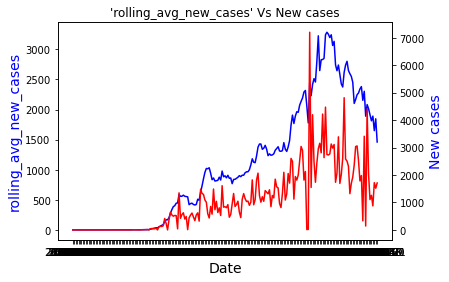

In [29]:
fig,ax = plt.subplots()
# make a plot
ax.plot(la_county.Date, la_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(la_county.Date, la_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

## Rolling window to compare every 2 weeks with next 2 weeks

In [31]:
NY_combined_data = NY_combined_data.sort_values(by=['Date'])
NY_combined_data.head()

,Date,FIPS,New cases,rolling_avg_new_cases,Province_State,Confirmed,Deaths,New deaths
0,2020-01-22,6001.0,0,0.0,California,0.0,0.0,0.0
12141,2020-01-22,6115.0,0,0.0,California,0.0,0.0,0.0
11289,2020-01-22,6107.0,0,0.0,California,0.0,0.0,0.0
1278,2020-01-22,6013.0,0,0.0,California,0.0,0.0,0.0
9798,2020-01-22,6093.0,0,0.0,California,0.0,0.0,0.0


In [32]:
NY_combined_data[NY_combined_data['FIPS'] == 6037]

,Date,FIPS,New cases,rolling_avg_new_cases,Province_State,Confirmed,Deaths,New deaths
3834,2020-01-22,6037.0,0,0.000000,California,0.0,0.0,0.0
3835,2020-01-23,6037.0,0,0.000000,California,0.0,0.0,0.0
3836,2020-01-24,6037.0,0,0.000000,California,0.0,0.0,0.0
3837,2020-01-25,6037.0,0,0.000000,California,0.0,0.0,0.0
3838,2020-01-26,6037.0,1,0.000000,California,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
4042,2020-08-17,6037.0,1259,1812.428571,California,223230.0,5273.0,19.0
4043,2020-08-18,6037.0,875,1890.142857,California,224105.0,5340.0,67.0
4044,2020-08-19,6037.0,1722,1649.142857,California,225827.0,5392.0,52.0
4045,2020-08-20,6037.0,1519,1845.857143,California,227346.0,5446.0,54.0


In [33]:
minDate = NY_combined_data['Date'].min()
print(minDate)

dateList = NY_combined_data['Date'].unique()

2020-01-22


In [34]:
import datetime

#dt_object = datetime.fromtimestamp(date)
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

day = datetime.datetime.strptime(minDate, '%Y-%m-%d').weekday()
if day == 6:
  day =0
elif day < 6:
  day += 1

print(day)

3


In [35]:
index = 0
count = 0
lst = []
while index < len(dateList):
  row = []
  j = 14 - day;
  # print(index,j)
  # print(dateList[index:index+j])
  weekRange = dateList[index:index+j]
  #print(weekRange)
  index = index+j 
  day = 0
  count +=1
  row.append(count)
  row.append(weekRange.min())
  row.append(weekRange.max())
  print(row)
  lst.append(row)
  


[1, '2020-01-22', '2020-02-01']
[2, '2020-02-02', '2020-02-15']
[3, '2020-02-16', '2020-02-29']
[4, '2020-03-01', '2020-03-14']
[5, '2020-03-15', '2020-03-28']
[6, '2020-03-29', '2020-04-11']
[7, '2020-04-12', '2020-04-25']
[8, '2020-04-26', '2020-05-09']
[9, '2020-05-10', '2020-05-23']
[10, '2020-05-24', '2020-06-06']
[11, '2020-06-07', '2020-06-20']
[12, '2020-06-21', '2020-07-04']
[13, '2020-07-05', '2020-07-18']
[14, '2020-07-19', '2020-08-01']
[15, '2020-08-02', '2020-08-15']
[16, '2020-08-16', '2020-08-21']


In [36]:
week_df = pd.DataFrame(lst,index=None,columns=['WeekNumber','startDate','endDate'])
week_df.head(2)

,WeekNumber,startDate,endDate
0,1,2020-01-22,2020-02-01
1,2,2020-02-02,2020-02-15


## Slice data for the week dataframe

In [38]:

average_newCases_df = pd.DataFrame(columns=[  'FIPS',  'average_per_week','startDate','endDate'])

for index, row in week_df.iterrows():
    startDate, endDate = row['startDate'], row['endDate']
    df_index = (NY_combined_data['Date'] >= startDate) & (NY_combined_data['Date'] <= endDate)
    df_weekData =  NY_combined_data.loc[df_index]
    df_base = (
      df_weekData
      .pipe(lambda x: x.assign(gains_pctg=x["rolling_avg_new_cases"]))
      .groupby(['FIPS'])
      .agg({"gains_pctg": "mean"})
      .reset_index()
      .rename(columns={"gains_pctg": "average_per_week"})
    )
    df_base['startDate'] = startDate
    df_base['endDate'] = endDate
  
    #print(startDate,endDate,df_base['average_per_week'])
    average_newCases_df = average_newCases_df.append(df_base)


In [ ]:
average_newCases_df.shape

In [39]:
average_newCases_df[average_newCases_df['FIPS'] == 6037]

,FIPS,average_per_week,startDate,endDate
18,6037.0,0.064935,2020-01-22,2020-02-01
18,6037.0,0.000000,2020-02-02,2020-02-15
18,6037.0,0.000000,2020-02-16,2020-02-29
18,6037.0,1.969388,2020-03-01,2020-03-14
18,6037.0,65.061224,2020-03-15,2020-03-28
18,6037.0,460.224490,2020-03-29,2020-04-11
18,6037.0,625.520408,2020-04-12,2020-04-25
18,6037.0,882.826531,2020-04-26,2020-05-09
18,6037.0,884.377551,2020-05-10,2020-05-23
18,6037.0,1259.887755,2020-05-24,2020-06-06


## Verifying average per week data Eg., albany County

In [40]:
la_county[(albany_county['Date'] >= '2020-03-01') & (la_county['Date'] <= '2020-03-14') ]['rolling_avg_new_cases']



3873    0.000000
3874    0.000000
3875    0.000000
3876    0.857143
3877    1.428571
3878    1.714286
3879    1.857143
3880    1.857143
3881    1.857143
3882    2.714286
3883    2.857143
3884    3.000000
3885    3.857143
3886    5.571429
Name: rolling_avg_new_cases, dtype: float64

In [41]:
average_newCases_df.head(10)

,FIPS,average_per_week,startDate,endDate
0,6001.0,0.0,2020-01-22,2020-02-01
1,6003.0,0.0,2020-01-22,2020-02-01
2,6005.0,0.0,2020-01-22,2020-02-01
3,6007.0,0.0,2020-01-22,2020-02-01
4,6009.0,0.0,2020-01-22,2020-02-01
5,6011.0,0.0,2020-01-22,2020-02-01
6,6013.0,0.0,2020-01-22,2020-02-01
7,6015.0,0.0,2020-01-22,2020-02-01
8,6017.0,0.0,2020-01-22,2020-02-01
9,6019.0,0.0,2020-01-22,2020-02-01


## Finding the % growth or reduction in 'new cases' on every 2 week average

In [42]:
average_newCases_df_ = average_newCases_df.copy()

In [43]:
albany_avg_newCases = average_newCases_df[average_newCases_df['FIPS'] == 6037]
albany_avg_newCases

,FIPS,average_per_week,startDate,endDate
18,6037.0,0.064935,2020-01-22,2020-02-01
18,6037.0,0.000000,2020-02-02,2020-02-15
18,6037.0,0.000000,2020-02-16,2020-02-29
18,6037.0,1.969388,2020-03-01,2020-03-14
18,6037.0,65.061224,2020-03-15,2020-03-28
18,6037.0,460.224490,2020-03-29,2020-04-11
18,6037.0,625.520408,2020-04-12,2020-04-25
18,6037.0,882.826531,2020-04-26,2020-05-09
18,6037.0,884.377551,2020-05-10,2020-05-23
18,6037.0,1259.887755,2020-05-24,2020-06-06


In [ ]:
# average_newCases_df = average_newCases_df.sort_values(by=['startDate','endDate'])

# print(average_newCases_df.shape)
# temp = average_newCases_df.groupby(['County Name','fips_x','startDate','endDate'])['average_per_week']
# temp = temp.sum().diff().reset_index()
# print("-------------")
# print(temp)
# print(temp.shape)

# average_newCases_df2 = average_newCases_df.merge(temp,on=['County Name','fips_x','startDate','endDate'])
# print(average_newCases_df2.shape)

In [ ]:
average_newCases_df.head()

In [ ]:
# average_newCases_df = average_newCases_df.sort_values(by=['startDate','endDate'])

# print(average_newCases_df.shape)
# temp = average_newCases_df.groupby(['County Name','fips_x','startDate','endDate'])['average_per_week']
# temp = temp.sum().diff().reset_index()
# print("-------------")
# print(temp)
# print(temp.shape)

# average_newCases_df2 = average_newCases_df.merge(temp,on=['County Name','fips_x','startDate','endDate'])
# print(average_newCases_df2.shape)

In [44]:
average_newCases_df2 = average_newCases_df.copy()

average_newCases_df2 = average_newCases_df2.reset_index(drop=True)
average_newCases_df2.head()

,FIPS,average_per_week,startDate,endDate
0,6001.0,0.0,2020-01-22,2020-02-01
1,6003.0,0.0,2020-01-22,2020-02-01
2,6005.0,0.0,2020-01-22,2020-02-01
3,6007.0,0.0,2020-01-22,2020-02-01
4,6009.0,0.0,2020-01-22,2020-02-01


In [46]:
average_newCases_df2['diff_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['FIPS'])['average_per_week'].diff().fillna(0)

print(average_newCases_df2.shape)
average_newCases_df2.head()


(944, 5)


,FIPS,average_per_week,startDate,endDate,diff_avg_x
0,6001.0,0.0,2020-01-22,2020-02-01,0.0
1,6003.0,0.0,2020-01-22,2020-02-01,0.0
2,6005.0,0.0,2020-01-22,2020-02-01,0.0
3,6007.0,0.0,2020-01-22,2020-02-01,0.0
4,6009.0,0.0,2020-01-22,2020-02-01,0.0


In [ ]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Yates County']

In [ ]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Albany County']

In [48]:
average_newCases_df2[average_newCases_df2['FIPS'] == 6037].head(5)

,FIPS,average_per_week,startDate,endDate,diff_avg_x
18,6037.0,0.064935,2020-01-22,2020-02-01,0.000000
77,6037.0,0.000000,2020-02-02,2020-02-15,-0.064935
136,6037.0,0.000000,2020-02-16,2020-02-29,0.000000
195,6037.0,1.969388,2020-03-01,2020-03-14,1.969388
254,6037.0,65.061224,2020-03-15,2020-03-28,63.091837


In [ ]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Yates County']

In [ ]:
average_newCases_df2.head()

In [49]:
average_newCases_df2 = average_newCases_df2.fillna(0)

In [ ]:
average_newCases_df2.head()

In [ ]:
#not working
#average_newCases_df2['pct_change_newcases'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x','startDate','endDate']).average_per_week_y.pct_change()

Shifting average_per_week_x	 column value for formula. Means previous row's value will be come to the current row.

In [51]:
average_newCases_df2['shift_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['FIPS'])['average_per_week'].shift()

In [ ]:
average_newCases_df2.groupby(by=['County Name', 'fips_x','startDate','endDate']).sum()

In [ ]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Yates County']

In [52]:
average_newCases_df2['percent_newcases'] = average_newCases_df2.apply(lambda x: (x.diff_avg_x) / x.shift_avg_x if x.shift_avg_x > 0.0 else 0 , axis=1)


average_newCases_df2.tail()


,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
939,6109.0,1.119048,2020-08-16,2020-08-21,-0.554422,1.673469,-0.331301
940,6111.0,99.000000,2020-08-16,2020-08-21,-31.897959,130.897959,-0.243686
941,6113.0,33.309524,2020-08-16,2020-08-21,3.901361,29.408163,0.132663
942,6115.0,17.976190,2020-08-16,2020-08-21,-0.278912,18.255102,-0.015279
943,90006.0,0.000000,2020-08-16,2020-08-21,0.000000,0.000000,0.000000


In [ ]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Yates County']

# Labeling data as per % change

In [ ]:
average_newCases_df2.describe()

In [53]:
la_county = average_newCases_df2[average_newCases_df2['FIPS'] == 6037]

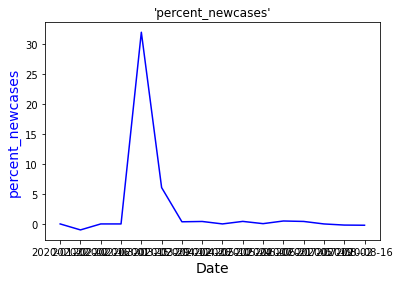

In [54]:
fig,ax = plt.subplots()
# make a plot
ax.plot(la_county.startDate, la_county['percent_newcases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("percent_newcases",color="blue",fontsize=14)
# ax2=ax.twinx()
# make a plot with different y-axis using second axis object
# ax2.plot(albany_county.startDate, albany_county["percent_newcases"],color="red")
# ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'percent_newcases'")

plt.show()

In [55]:
data = average_newCases_df2['percent_newcases'].to_list()

print(data)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.714285714285714, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -0.25000000000000006, 0.0, 0.0, 0.0, 0.0, 0.0, -0.9166666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0

In [56]:
average_newCases_df3 = average_newCases_df2.copy().reset_index(drop=True)

## Jenks Natural breaks 

In [57]:
!pip install jenkspy


     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for jenkspy: filename=jenkspy-0.1.5-cp36-cp36m-linux_x86_64.whl size=69064 sha256=bdb977bd017eaea23e77a741136782e42e3029d7c45c5ab15058005621142c42
  Stored in directory: /root/.cache/pip/wheels/14/1d/b0/45b9ac586dd190ca029df1965fe9f497327506376d51422475
Successfully built jenkspy


In [78]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=3)
print(breaks)

[-2.2, 44.0, 158.0, 377.00000000000006]


In [77]:

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=4)
print(breaks)

[-2.2, 13.882352941176471, 58.923076923076934, 158.0, 377.00000000000006]


[-1.1363636363636362, 39.5, 213.91325695581014, 410.1818181818182]

In [59]:
breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=8)
print(breaks)

[-2.2, 1.9999999999999998, 7.458333333333333, 16.500000000000007, 37.282051282051285, 58.923076923076934, 86.23809523809521, 158.0, 377.00000000000006]


### Labeling criteria

We have applied "jenks Natural breaks' to label the county data as per 'percent change in cases'

From the natural break algorithm, we have splited the data as follows 

* -1.136 to 3.642 is **label 1** (least chance of spreading) 

* 3.642 to 13.625 is **label 2** (Below threshold but chances to reach super spread level)

* 13.625 to 410.181818 is **label 3** (Super spread week)

In [79]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread'])

In [75]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread1','SuperSpread2','SuperSpread3','SuperSpread4','SuperSpread5','SuperSpread6'])

ValueError: ignored

In [80]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['FIPS'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['FIPS'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']['FIPS'].count())

Number of records in LessSpread: 939
Number of records in Spread: 3
Number of records in SuperSpread: 1


In [62]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['FIPS'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['FIPS'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread1']['FIPS'].count())
print('Number of records in SuperSpread2:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['FIPS'].count())


print('Number of records in SuperSpread3:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread3']['FIPS'].count())

print('Number of records in SuperSpread4:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread4']['FIPS'].count())

print('Number of records in SuperSpread5:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread5']['FIPS'].count())

print('Number of records in SuperSpread6:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread6']['FIPS'].count())




Number of records in LessSpread: 833
Number of records in Spread: 75
Number of records in SuperSpread: 19
Number of records in SuperSpread2: 11
Number of records in SuperSpread3: 2
Number of records in SuperSpread4: 1
Number of records in SuperSpread5: 1
Number of records in SuperSpread6: 1


In [ ]:
average_newCases_df2.head()

# Labeling data for NY combined

In [ ]:
NY_combined_data.head()

In [ ]:
NY_combined_data_ = NY_combined_data.copy()



In [ ]:
NY_combined_data = NY_combined_data_.copy().reset_index(drop=True)

In [ ]:
#average_newCases_df = pd.DataFrame(columns=['County Name',  'fips_x',  'average_per_week','startDate','endDate'])

for index, row in (average_newCases_df2.iterrows()):
    startDate, endDate = row['startDate'], row['endDate']
    fips = row['fips_x']
    #print(startDate,endDate,fips)
    df_index = (NY_combined_data['fips_x'] == row['fips_x']) & (NY_combined_data['Date'] >= startDate) & (NY_combined_data['Date'] <= endDate)
    df_weekData =  NY_combined_data.loc[df_index]
    #print(df_weekData)
    NY_combined_data.loc[df_index,'label'] = row['labels']




In [ ]:
NY_combined_data.head()

In [ ]:
NY_combined_data[NY_combined_data['label'] == 'SuperSpread'].sort_values(by=['fips_x','Date'])

In [ ]:
average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']

## Kernal Density Estimation

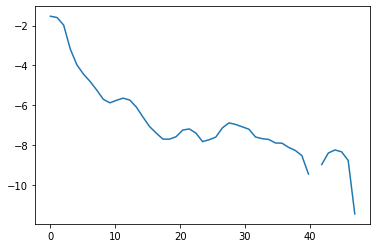

In [66]:
%matplotlib inline

from numpy import array, linspace
from sklearn.neighbors.kde import KernelDensity
from matplotlib.pyplot import plot

a = array(data).reshape(-1, 1)
kde = KernelDensity(kernel='epanechnikov', bandwidth=3).fit(a)
s = linspace(0,50)
e = kde.score_samples(s.reshape(-1,1))
plot(s, e)

In [67]:


from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print("Maxima:", s[ma])

Minima: [ 9.18367347 18.36734694 23.46938776 40.81632653]
Maxima: [11.2244898  21.42857143 27.55102041 43.87755102]


In [69]:
lower_range = s[mi][0]
upper_range = s[mi][1]

print(lower_range,upper_range)

9.183673469387756 18.367346938775512


In [70]:
print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

[-1.1363636363636362, 39.5, 213.91325695581014, 410.1818181818182]

Minima: [19.3877551  33.67346939]
Maxima: [24.48979592 39.79591837]*italicized text*

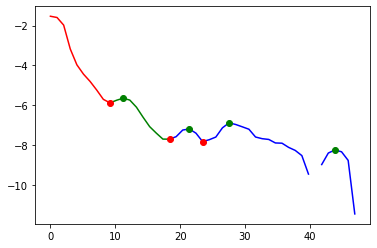

In [71]:
plot(s[:mi[0]+1], e[:mi[0]+1], 'r',
     s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g',
     s[mi[1]:], e[mi[1]:], 'b',
     s[ma], e[ma], 'go',
     s[mi], e[mi], 'ro')

print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


## Labeling Data with Kernal density results

In [72]:
average_newCases_df3.head()

,FIPS,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
0,6001.0,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0
1,6003.0,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0
2,6005.0,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0
3,6007.0,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0
4,6009.0,0.0,2020-01-22,2020-02-01,0.0,NaN,0.0


In [73]:
print(lower_range, upper_range)

9.183673469387756 18.367346938775512


In [ ]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range  else 'SuperSpread')


In [ ]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range else ('Spread' if (x >= lower_range and x <= upper_range) else 'SuperSpread'))



#converter = lambda x : x*2 if x < 10 else (x*3 if x < 20 else x)



In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'lessSpread'].count()

In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'Spread'].count()

In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'SuperSpread'].count()

In [ ]:
average_newCases_df3.head()

# unused code


In [ ]:
average_newCases_df2[average_newCases_df2['County Name'] != 'Queens County']

In [ ]:
average_newCases_df2.groupby(by=['County Name', 'fips_x','startDate','endDate']).sum()

In [ ]:
week_df.head()

In [ ]:
NY_combined_data.dtypes

In [ ]:
start_date_df = (
    NY_combined_data
    .merge(week_df, left_on=['Date'],right_on=['startDate'], how='inner')
    .pipe(lambda x: x.assign(date=x.Date))
    .rename(columns={"starting_rolling_avg_new_cases": "rolling_avg_new_cases"})
    .reset_index(drop=True)

    [['Date','fips_x','County Name','retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index','population_density','mask_rule_active','mask_wearing_percent','New cases','startDate','WeekNumber','rolling_avg_new_cases']]
    .pivot_table(values='rolling_avg_new_cases', columns='WeekNumber', index='County Name', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)

start_date_df

In [ ]:
end_date_df = (
    NY_combined_data
    .merge(week_df, on='Date', how='inner')
    .pipe(lambda x: x.assign(date=x.Date))
    .rename(columns={"Confirmed": "end_date_Confirmed"})
    .reset_index(drop=True)

    [['County Name', 'fips_x', 'end_date_Confirmed','endDate','WeekNumber']]
    .pivot_table(values='end_date_Confirmed', columns='WeekNumber', index='County Name', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)